<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>



## Comparison of hyper parameter tuning methods in machine-learning and deep-learning models
#### Dongyoung Yoon
#### Hildebrand Department of Petroleum and Geosystems Engineering Cockrell School of Engineering

### Subsurface Machine Learning Course The University of Texas at Austin


_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz Ph.D. P.Eng. Associate Professor The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales Graduate Student The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)

### Executive Summary

#### What is the gap problem opportunity scientific question?

* Hyperparameter-tuning is a necessary procedure to optimize the model. One of the most widely used hyperparameter-tunning approaches is grid search; however it becomes time-consuming as the model gets complex (increased number of hyperparameters). Therefore we need to apply alternative approaches of hyperparameter tuning for a model with a significant number of hyperparameters. 
* In this workflow two additional hyperparameter tuning methods which are random search and bayesian optimization based search (named bayes search in this workflow) will be applied and the results will be compared with the grid search results. This study will provide an overall idea of which hyperparameter strategy to use in a particular situation and study the pros and cons of each method

#### What was done to address the above?
* The dataset with reservoir characteristics and production is used in this workflow. Two regression models random forest regressor and artificial-neural networks (ANN) regressor are used to predict the production from given predictor variables. 
* Single class is built which helps simplify the hyperparameter tuning. The optimized hyperparameter and results can be obtained from the object from the built-in class
* The models with optimized hyperparameters from different methods are trained by training data and tested with testing data
* Finally the required iteration number to obtain the optimized hyperparameter and model errors from different models are compared.

#### What was learned?

* Bayesian optimization can significantly reduce the hyperparameter tuning time while obtaining same or better hyperparameters compared to grid search or random search
* The advantages of bayesian optimization becomes much greater as the model gets more complex (increased # of hyperparameter)
* Also, it is better to apply bayesian optimization where there is continuous value with large range of hyperparameter space
* For simple model and known hyperparmeter space, grid search or random search can be used

#### What are your recommendations?

* Use Bayesian optimization for hyperparameter tunning if the model has large number of hyperparameter and takes long time to train
* Random search or grid search can be applied for simple model
* Grid search can be applied to test the effect of hyperparameter to the model since we can control the hyperparameter that is tested 

### Overall workflow

#### 0. Import Packages

#### 1. Define class for hyperparameter tuning

#### 2. Loading the Data

#### 3. Data preparation and Cleaning

#### 4. Hyperparameter Tuning- Random Forest Regressor

#### 5. Results 1 

#### 6. Hyperparameter Tunning - ANN Regressor

#### 7. Results 2

#### 8. Summary

#### 9. Appendix - Bayesian optimization
 
The results include the comparison of the required iteration to get optimized hyperparameter and MSE of the optimized regressor from different methods (results1 for random forest regressor and results2 for ANN regressor)

Figure below illustrates the work flow used for hyperparameter tunning 

<p align="center">
    <img src="https://github.com/dyyoon91//ML_lecture//blob//main//CV_image-min.png?raw=true" width="700" height="700" />

</p>
    
 * 4-fold cross validation with 3 different approaches
 * 75% training data 25% testing data 
 

### 0. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import pandas.plotting as pd_plot
from scipy.stats import randint

# Packages from sklearn
from sklearn.metrics import mean_squared_error        
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, KFold

# packages is for bayesian optimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials                  

# Creates table
from tabulate import tabulate                                          

# Packages related to tensorflow for ANN regressor
import tensorflow as tf                                                
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')


**►** Set the seed value to get repeatable results:
The following code block is from stackoverflow: https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds

In [2]:
# seed value
seed_value= 2022

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

### 1. Define class for hyperparameter tuning

Class named 'ParamsOpt' is built to simplify the hyperparameter process. Optimum hyperparameter is searched by cross validation.
The hyperparmeter tuning method is controlled with 'searchType'
Below summarizes the parameters attributes and Methods

**Parameters**

* **model**: Any built-in ML model which can set parameter by 'set_params()' method

* **params**: Search space of hyperparameters (dict)

* **X_train**: Predictor variables of training dataset (DataFrame)

* **y_train**: Response variables of training dataset (DataFrame)

* **searchType**: Hyperparameter tuning methods (str)
 * 'grid' : grid search
 * 'rand' : random search
 * 'bayes' : bayesian optimization
 
* **scoring** : Strategy to evaluate the performance of the cross-validated model (str) 
 * see https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search for metrics for evaluation
 
* **cv**: Determines the cross-validation splitting strategy (int cross-validation generator)

* **random_iter** : Iteration number for random search (int)

* **bayes_iter** : Iteration number for bayes search (int)

**Attributes**

* **res**: 
 * If searchType is 'grid' or 'rand' it returns objective from GridSearchCV or RandomizedSearchCV respectively. 
 * If searchType is 'bayes' it returns the dictionaries of bayesian search log results

* **yx**: -1 * Mean value of test socre 

* **xs**: Iteration number

* **opt_ys**: Optimized test score in this workflow it gives minimum mean squared error

* **opt_xs**: Iteration number of optimized hyperparameter

* **best_params_**: Hyperparameters that results in best performace obtaind by cross validation and given test score

**Methods**

 * **Optimize()**: Runs the hyperparameter tuning and summarizes the results
 * **f(params)**: Method that is used inside optimize() for bayesian search. objective function of bayesian search
 
Details of bayesian search can be seen in Appendix

In [3]:
class ParamsOpt:
    
    searchType_list = {
        'grid': ['grid', 'gridsearch', 'Grid', 'Gridsearch'],
        'rand': ['rand', 'random', 'randomsearch', 'Rand', 'Random', 'Randomsearch'],
        'bayes':['bayesian', 'bayes', 'Bayesian', 'Bayes']
    }

    def __init__(self, model, params, X_train, y_train, searchType, scoring='neg_mean_squared_error', 
                 cv=5, random_iter=50, bayes_iter=50):
        self.model = model
        self.params = params
        self.scoring = scoring
        self.searchType = searchType
        self.cv = cv
        self.random_iter = random_iter
        self.bayes_iter = bayes_iter
        self.X_train = X_train
        self.y_train = y_train
        
        self.res = None
        self.yx = None
        self.xs = None
        self.opt_xs = None
        self.opt_ys = None
        self.best_params_ = None

    
    def f(self, params):
        """
        Methods for bayesian optimization.
        objective function that to be optimized- mean value of MSE from cross validation.
        In this example it is the mean value of negative MSE from cross validation defined in hyperopt_train_test.
        """
        self.model = self.model.set_params(**params)
        res_ = np.average(cross_val_score(estimator= self.model,
                               X= self.X_train, 
                               y= self.y_train, 
                               scoring= self.scoring, 
                               cv= self.cv))
        return {'loss': - res_, 'status': STATUS_OK}

      
    def optimize(self):
        """
        Run the cross validation based on searchType.
        GridsearchCV and RandomizedSearchCV from sklearn are used for grid search and random search respectively.
        fmin from hyperopt is used for bayesian optimization 
            fmin finds the minimum of objective function (f) 
            Tree Parzen Estimator (TPE) surrogate function with Expectation improvement (EI) is used to find 
            the next search value (tpe.suggest) - more detail can be seen from the Appendix
        """
        # grid search
        if self.searchType in self.searchType_list['grid']:
            self.res = GridSearchCV(estimator=self.model, param_grid=self.params, 
                              scoring = self.scoring, cv=self.cv)
            self.res.fit(self.X_train, self.y_train)
        
        # random seach
        elif self.searchType in self.searchType_list['rand']:
            self.res =  RandomizedSearchCV(estimator=self.model, param_distributions=self.params, 
                          scoring = self.scoring, cv=self.cv, n_iter=self.random_iter)
            self.res.fit(self.X_train, self.y_train)
         
        # bayesian optimization
        elif self.searchType in self.searchType_list['bayes']:
            self.res = Trials()
            best_params_ = fmin(self.f, self.params, algo=tpe.suggest, 
                                max_evals=self.bayes_iter, trials=self.res,
                                    return_argmin=False)
        # wrong searchType input
        else:
            print('check the searchType input')
         
        """
        Get results
        """
        # grid search or random search results
        if self.searchType in self.searchType_list['grid'] + self.searchType_list['rand']:
            self.ys= -1 * self.res.cv_results_['mean_test_score'].copy()
            self.xs = np.arange(len(self.ys))
            
            opt_idx = np.argmin(self.ys)
            self.opt_xs = self.xs[opt_idx]
            self.opt_ys = self.ys[opt_idx]
            self.best_params_ = self.res.best_params_

        # bayesian optimization restuls
        elif self.searchType in self.searchType_list['bayes']:
            self.ys = [t['result']['loss'] for t in self.res.trials] 
            self.xs = np.arange(len(self.ys))
            
            opt_idx = np.argmin(self.ys)
            self.opt_ys = self.ys[opt_idx]
            self.opt_xs = self.xs[opt_idx]
            self.best_params_ = best_params_

### 2. Loading Data

'unconv_MV.csv' data from  https://github.com/GeostatsGuy/GeoDataSets is used

The dataset consist of eight subsurface features (predictor variables) which are:

* **Wellindex** - Well index
* **Por** - fraction of rock void in units of percentage 
* **LogPerm** - log scaled permeability [$mDarcy$]
* **AI** - product of sonic velocity and rock density  [$kg/m^2s*10^3$]
* **Brittle** - Brittleness index 
* **TOC** - Total organic carbon [$wt%$]
* **VR** - vitrinite reflectance [%]

and response variable which is: 

* **Production** - normalized initial production 90 day average [$MCFPD$]. 

In [4]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv")

### 3. Data preparation and cleaning

The code for section 3 is cited from https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Gradient_Boosting.ipynb

**►** Check the first few rows of the data:


In [5]:
df.head(10)

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285
7,8,14.15,1.23,2.53,39.43,0.79,1.54,1943.639213
8,9,16.18,1.34,3.45,45.79,0.56,1.95,3176.523611
9,10,20.51,2.48,2.78,28.99,1.78,2.24,2522.792318


**►** Remove the well index and check the summary statistics:

In [6]:
df = df.drop(['WellIndex'], axis=1)                        # Wellindex column removed,
df.describe().transpose()                                  # Calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


**►** Truncate the negative values from the dataframe

In [7]:
num = df._get_numeric_data()                           # get the numerical values
num[num < 0] = 0                                       # truncate negative values to 0.0
df.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


**►** Check the distribution and range of the variables from the matrix scatter plot

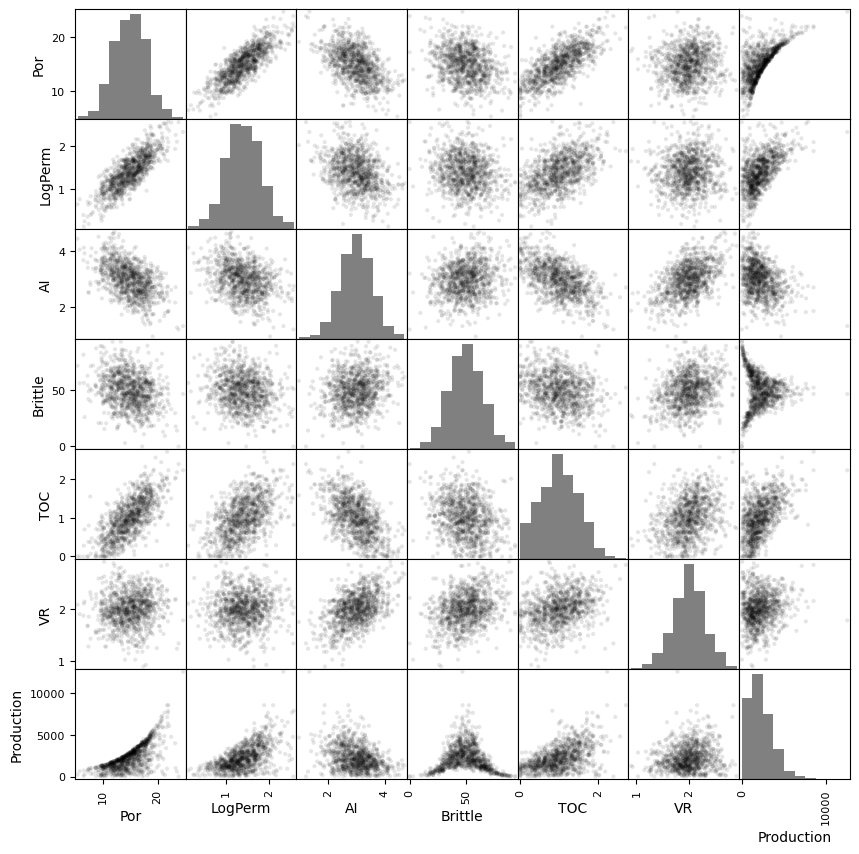

In [8]:
pd_plot.scatter_matrix(df, alpha = 0.1,                # pandas matrix scatter plot
figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

From the matrix plot, it can be shown that the predictor variables are normally distributed. <br/>
Some correlation between predictor variables (i.e., porosity and log permeability) can be seen. However, we will use all of the features in this workflow since we will focus more on hyperparameter tuning

**►** Split data to training and testing data

In [9]:
X = df.drop(['Production'], axis=1)                       # Predictor variables,
y = df['Production']                                 # Response variable,
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 4. Hyperparameter tuning for random forest regressor
  
**►** Define the search space:

In [10]:
param_grid ={                                                          # search space for grid search
        'max_depth': np.arange(1,10),
        'max_features': np.arange(1,7),
        'max_leaf_nodes': np.arange(2, 100, 20)
    } 
    
param_rand ={
    'max_depth': randint(1,10),                                        # search space for random search
    'max_features': randint(1,7),
    'max_leaf_nodes': randint(2, 100)
} 
    
param_bayes = {                                                        # search space for bayesian search
    'max_depth': hp.choice('max_depth', range(1,10)),
    'max_features': hp.choice('max_features', range(1,7)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2,100))
}

Total tree hyperparameters are tuned which are 1) maximum depth of the decision tree, 2) the number of features to consider for best split, and 3) maximum number of the leaf nodes

For param_rand, discrete uniform distribution is used. Alternative distributions can also possibly be applied. It should be cautious in setting the search space. For example, all the hyperparameters used in this workflow should be integers and max_leaf_nodes should be larger than 2. For param_bayes, hp.choice is used for simplicity and also because the hyperparameters should be an integer. Different search spaces can be applied, such as from normal distribution. More details can be seen from the link: http://hyperopt.github.io/hyperopt/getting-started/search_spaces

**►** Build objectives for different tuning methods:

In [11]:
cv= KFold(n_splits=4)                 # define cv value

grid_rf = ParamsOpt(model = RandomForestRegressor(random_state=42), params = param_grid,    # grid search
                    X_train = X_train, y_train = y_train, searchType='grid', cv=cv)

rand_rf = ParamsOpt(model = RandomForestRegressor(random_state=42), params = param_rand,    # random search
                    X_train = X_train, y_train = y_train, searchType='rand', cv=cv)

bayes_rf = ParamsOpt(model = RandomForestRegressor(random_state=42), params = param_bayes,  # bayes search
                    X_train = X_train, y_train = y_train, searchType='bayes', cv=cv)

**►** Conduct hyperparameter tuning by optimize() method:

In [12]:
grid_rf.optimize()
rand_rf.optimize()
bayes_rf.optimize()

100%|████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79trial/s, best loss: 125807.46499154641]


### 5. Results - random forest regressor
  
**►** Iteration-MSE plot for each search method:

Grid search: Iteration # for optimized value 269, optimized MSE 126228.97444560882
Random search: Iteration # for optimized value 34, optimized MSE 130339.39679420934
Bayesian opt: Iteration # for optimized value 44, optimized MSE 125807.46499154641


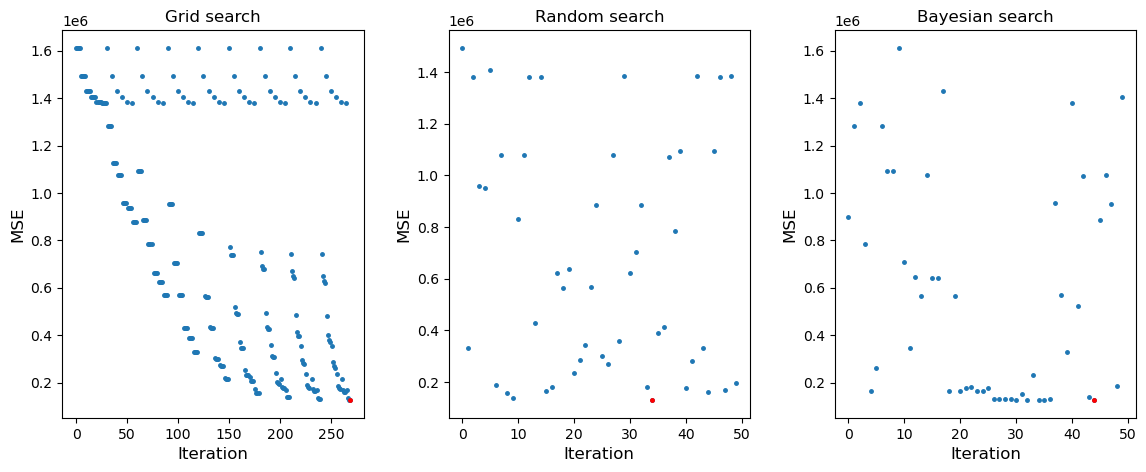

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.tight_layout(pad = 3)

ax[0].plot(grid_rf.xs, grid_rf.ys, 'o', markersize=2.5, color='tab:blue')
ax[0].plot(grid_rf.opt_xs, grid_rf.opt_ys, 'o', markersize=2.5, color='red')
ax[0].set_xlabel('Iteration', fontsize=12)
ax[0].set_ylabel('MSE',fontsize=12)
ax[0].set_title('Grid search', fontsize=12)

ax[1].plot(rand_rf.xs, rand_rf.ys, 'o', markersize=2.5, color='tab:blue')
ax[1].plot(rand_rf.opt_xs, rand_rf.opt_ys, 'o', markersize=2.5, color='red')
ax[1].set_xlabel('Iteration', fontsize=12)
ax[1].set_ylabel('MSE',fontsize=12)
ax[1].set_title('Random search', fontsize=12)


ax[2].plot(bayes_rf.xs, bayes_rf.ys, 'o', markersize=2.5, color='tab:blue')
ax[2].plot(bayes_rf.opt_xs, bayes_rf.opt_ys, 'o', markersize=2.5, color='red')
ax[2].set_xlabel('Iteration', fontsize=12)
ax[2].set_ylabel('MSE',fontsize=12)
ax[2].set_title('Bayesian search', fontsize=12)

print(f'Grid search: Iteration # for optimized value {grid_rf.opt_xs}, optimized MSE {grid_rf.opt_ys}')
print(f'Random search: Iteration # for optimized value {rand_rf.opt_xs}, optimized MSE {rand_rf.opt_ys}')
print(f'Bayesian opt: Iteration # for optimized value {bayes_rf.opt_xs}, optimized MSE {bayes_rf.opt_ys}')


plt.show()

Each figure represents the iteration-MSE plot for grid search, random search, and bayesian search. The red scatter plot indicates the minimum MSE value during the iteration. Also, the minimum MSE value and iteration number when the minimum MSE was obtained are shown above the figures. The comparison of different methods can be seen in more detail from the next code block
 
**►** Iteration-MSE plot for each search method in single figure and table summarizing the results:

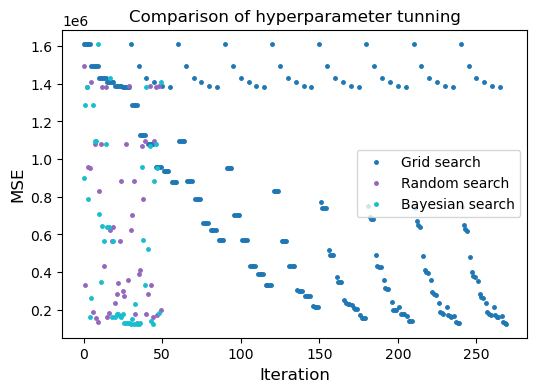

Table 1
╒════════════════╤════════╤════════╤═════════╕
│                │   grid │   rand │   bayes │
╞════════════════╪════════╪════════╪═════════╡
│ Minimum MSE    │ 126229 │ 130339 │  125807 │
├────────────────┼────────┼────────┼─────────┤
│ Max_depth      │      9 │      8 │       9 │
├────────────────┼────────┼────────┼─────────┤
│ max_features   │      6 │      6 │       6 │
├────────────────┼────────┼────────┼─────────┤
│ max_leaf_nodes │     82 │     69 │      92 │
╘════════════════╧════════╧════════╧═════════╛


In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(grid_rf.xs, grid_rf.ys, 'o', markersize=2.5, color='tab:blue', label='Grid search')
ax.plot(rand_rf.xs, rand_rf.ys, 'o', markersize=2.5, color='tab:purple', label='Random search')
ax.plot(bayes_rf.xs, bayes_rf.ys, 'o', markersize=2.5, color='tab:cyan', label='Bayesian search')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('MSE',fontsize=12)
ax.set_title('Comparison of hyperparameter tunning', fontsize=12)
ax.legend()

plt.show()

# Dictionary for optimized hyperparmeters from different methods
grid_opt_params_rf = {
    'max_depth': grid_rf.best_params_['max_depth'],
    'max_features': grid_rf.best_params_['max_features'],
    'max_leaf_nodes': grid_rf.best_params_['max_leaf_nodes'],
}

rand_opt_params_rf = {
    'max_depth': rand_rf.best_params_['max_depth'],
    'max_features': rand_rf.best_params_['max_features'],
    'max_leaf_nodes': rand_rf.best_params_['max_leaf_nodes'],
}

bayes_opt_params_rf = {
    'max_depth': bayes_rf.best_params_['max_depth'],
    'max_features': bayes_rf.best_params_['max_features'],
    'max_leaf_nodes': bayes_rf.best_params_['max_leaf_nodes'],
}

# Build table to summarize the results 
table = [
    ['Minimum MSE', grid_rf.opt_ys, rand_rf.opt_ys, bayes_rf.opt_ys],
    ['Max_depth', grid_opt_params_rf['max_depth'], rand_opt_params_rf['max_depth'], bayes_opt_params_rf['max_depth']],
    ['max_features', grid_opt_params_rf['max_features'], rand_opt_params_rf['max_features'], bayes_opt_params_rf['max_features']],
    ['max_leaf_nodes', grid_opt_params_rf['max_leaf_nodes'], rand_opt_params_rf['max_leaf_nodes'], bayes_opt_params_rf['max_leaf_nodes']]
        ]

print('Table 1'),
print(tabulate(table, headers=['grid', 'rand', 'bayes'], tablefmt='fancy_grid'))


* Grid search requires more than 250 iterations to get the optimum hyperparameter while random and bayesian search obtained the minimum MSE from less than 50 iterations.,
* Bayesian search showed minimum MSE. this is because it was able to expand the search space compared to grid search (it will require too much time if we use the same search space for grid search). If rand_iter (maximum number of iterations for random search) is large enough, it will get the same minimum MSE to bayes search
* The model is not too complicated; therefore showed similar results from different methods. However bayesian search showed the best performance for MSE score from this workflow 
* The optimized hyperparameters for each method are summarized in table 1
 
 
-> if the bayes's minimum MSE is larger than grid (depending on working envorionmnet), you can slightly increase the  and will give lower MSE within lessor iteration of 250

**►** Refit the model with obtained hyperparameter with entire training data and calculate the MSE for training and testing data:

In [15]:
model_grid_rf = RandomForestRegressor(**grid_opt_params_rf, random_state=42)   # RF regressor with hyperparameter from grid search
model_grid_rf.fit(X_train, y_train)                                            
y_pred_train_grid_rf = model_grid_rf.predict(X_train)
y_pred_test_grid_rf = model_grid_rf.predict(X_test)

model_rand_rf = RandomForestRegressor(**rand_opt_params_rf, random_state=42)   # RF regressor with hyperparameter from random search
model_rand_rf.fit(X_train, y_train)
y_pred_train_rand_rf = model_rand_rf.predict(X_train)
y_pred_test_rand_rf = model_rand_rf.predict(X_test)

model_bayes_rf = RandomForestRegressor(**bayes_opt_params_rf, random_state=42)  # RF regressor with hyperparameter from bayes search
model_bayes_rf.fit(X_train, y_train)
y_pred_train_bayes_rf = model_bayes_rf.predict(X_train)
y_pred_test_bayes_rf = model_bayes_rf.predict(X_test)

# Calculate MSE from training data
mse_train_grid_rf = mean_squared_error(y_train, y_pred_train_grid_rf)     
mse_train_rand_rf = mean_squared_error(y_train, y_pred_train_rand_rf)
mse_train_bayes_rf = mean_squared_error(y_train, y_pred_train_bayes_rf)

# Calculate MSE from testing data
mse_test_grid_rf = mean_squared_error(y_test, y_pred_test_grid_rf)
mse_test_rand_rf = mean_squared_error(y_test, y_pred_test_rand_rf)
mse_test_bayes_rf = mean_squared_error(y_test, y_pred_test_bayes_rf)

**►** Regression results for training data from optained hyperparameter from each method:

Table 2
╒═════════════════════╤═════════╤═════════╤═════════╕
│                     │    grid │    rand │   bayes │
╞═════════════════════╪═════════╪═════════╪═════════╡
│ MSE (training data) │ 16884.8 │ 21194.6 │ 16205.4 │
╘═════════════════════╧═════════╧═════════╧═════════╛


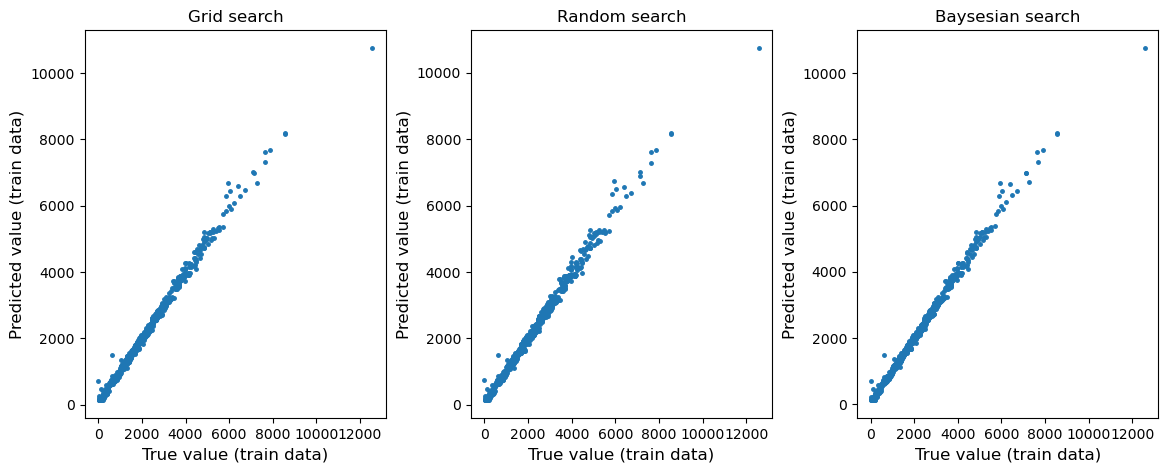

In [16]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.tight_layout(pad = 3)

ax[0].plot(y_train, y_pred_train_grid_rf, 'o', markersize=2.5, color='tab:blue')
ax[0].set_xlabel('True value (train data)', fontsize=12)
ax[0].set_ylabel('Predicted value (train data)',fontsize=12)
ax[0].set_title('Grid search', fontsize=12)

ax[1].plot(y_train, y_pred_train_rand_rf, 'o', markersize=2.5, color='tab:blue')
ax[1].set_xlabel('True value (train data)', fontsize=12)
ax[1].set_ylabel('Predicted value (train data)',fontsize=12)
ax[1].set_title('Random search', fontsize=12)

ax[2].plot(y_train, y_pred_train_bayes_rf, 'o', markersize=2.5, color='tab:blue')
ax[2].set_xlabel('True value (train data)', fontsize=12)
ax[2].set_ylabel('Predicted value (train data)',fontsize=12)
ax[2].set_title('Baysesian search', fontsize=12)

print('Table 2')
table = [['MSE (training data)', mse_train_grid_rf, mse_train_rand_rf, mse_train_bayes_rf]]
print(tabulate(table, headers=['grid', 'rand', 'bayes'], tablefmt='fancy_grid'))

plt.show()

Table 2 summarizes the MSE from training data. Bayesian optimization showed lowest MSE
    
**►** Regression results for testing data from optained hyperparameter from each method:

Table 3
╒═════════════════════╤═════════╤═════════╤═════════╕
│                     │    grid │    rand │   bayes │
╞═════════════════════╪═════════╪═════════╪═════════╡
│ MSE (training data) │ 30065.6 │ 33500.1 │ 29370.4 │
╘═════════════════════╧═════════╧═════════╧═════════╛


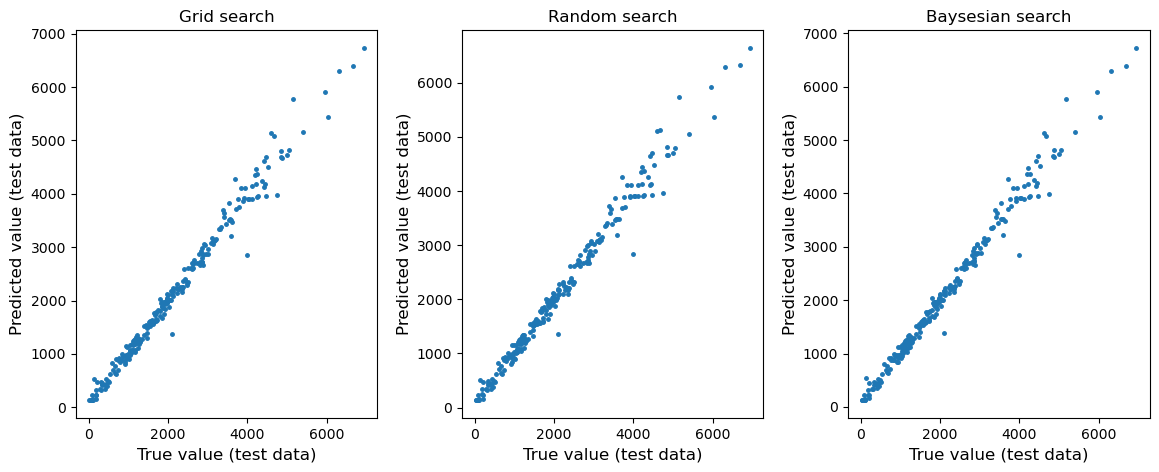

In [17]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.tight_layout(pad = 3)

ax[0].plot(y_test, y_pred_test_grid_rf, 'o', markersize=2.5, color='tab:blue')
ax[0].set_xlabel('True value (test data)', fontsize=12)
ax[0].set_ylabel('Predicted value (test data)',fontsize=12)
ax[0].set_title('Grid search', fontsize=12)

ax[1].plot(y_test, y_pred_test_rand_rf, 'o', markersize=2.5, color='tab:blue')
ax[1].set_xlabel('True value (test data)', fontsize=12)
ax[1].set_ylabel('Predicted value (test data)',fontsize=12)
ax[1].set_title('Random search', fontsize=12)

ax[2].plot(y_test, y_pred_test_bayes_rf, 'o', markersize=2.5, color='tab:blue')
ax[2].set_xlabel('True value (test data)', fontsize=12)
ax[2].set_ylabel('Predicted value (test data)',fontsize=12)
ax[2].set_title('Baysesian search', fontsize=12)

print('Table 3')
table = [['MSE (training data)', mse_test_grid_rf, mse_test_rand_rf, mse_test_bayes_rf]]
print(tabulate(table, headers=['grid', 'rand', 'bayes'], tablefmt='fancy_grid'))

plt.show()

Table 3 summarizes the MSE from testing data. Bayesian optimization showed lowest MSE 

### 6. Hyperparameter tuning for artificial neural networks regression,

**►** function building keras sequential model to use in KerasRegressor wrapper

In [18]:
def ANN_regressor(learning_rate = 0.001, neurons=32, dropout=0.0, batch_size = 16, epochs=50, activation='relu', loss='mse'):
    """
    ANN regressor with 1 hidden layers
    Adam optimizer is used
    
    learning rate, neurons, dropout, batch size, epochs, activation function , loss are the parameters of the function
    which can be controlled
    
    """
    model = Sequential()
    model.add(Dense(neurons, input_shape=(X_train.shape[1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    optimizer = Adam(lr= learning_rate)
    model.compile(optimizer = optimizer, loss=loss)

    return model

**►** Standardize the data for ANN regression:

In [19]:
scaler = StandardScaler()
df_sc = scaler.fit_transform(df)
df_sc = pd.DataFrame(df_sc, columns=df.columns)

To improve the backpropagation stability and speed and also to prevent certain node being dominated we will use standardized data for ANN 

**►** Split scaled data into training and testing data:

In [20]:
X_sc = df_sc.drop(['Production'], axis=1)
y_sc = df_sc['Production']


X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(
                                        X_sc, y_sc, test_size=0.25, random_state=42)

**►** ANN estimater based on KerasRegressor wrapper:

In [21]:
clf = KerasRegressor(build_fn = ANN_regressor, verbose=0)

**►** Define the search space:

In [22]:
param_grid_ANN ={
    'learning_rate': [0.0001, 0.001],
    'activation': ['relu', 'sigmoid'],
    'epochs': [50, 100],
    'batch_size': [8, 16],
    'neurons': [5, 10],
    'dropout': [0.0, 0.3],
} 

param_rand_ANN ={
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'activation': ['relu', 'sigmoid'],
    'epochs': [50, 100],
    'batch_size': [8, 16],
    'neurons': randint(3,10),
    'dropout': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
} 

param_bayes_ANN ={
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.0005, 0.001, 0.005, 0.01]),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'epochs': hp.choice('epochs', [50,100]),
    'batch_size': hp.choice('batch_size', [8,16]),
    'neurons': hp.choice('neurons', range(3, 10)),
    'dropout': hp.choice('dropout', [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]),
} 

Total six hyperparameter will be tuned which are: 1) learning rate, 2) activation function, 3) epochs, 4) batch size, 5) number of neurons in hidden layer and 6) dropout rate

**►** Build objectives for different tuning methods:

In [23]:
cv= KFold(n_splits=4)

grid_ANN = ParamsOpt(model = clf, params = param_grid_ANN,                                                 # grid search
                    X_train = X_train_sc, y_train = y_train_sc, searchType='grid', cv=cv)
rand_ANN = ParamsOpt(model= clf, params = param_rand_ANN,                                                  # random search
                    X_train = X_train_sc, y_train = y_train_sc, searchType='rand', cv=cv, random_iter=50)
bayes_ANN = ParamsOpt(model=clf, params= param_bayes_ANN,                                                  # bayes search
                 X_train = X_train_sc, y_train = y_train_sc, searchType='bayes', cv=cv, bayes_iter=50)

**►** Conduct hyperparameter tuning by optimize() method: 
* This code block can take a lot time depending on your search space and iteration number 

In [24]:
grid_ANN.optimize()
rand_ANN.optimize()
bayes_ANN.optimize()

100%|██████████████████████████████████████████████| 50/50 [09:44<00:00, 11.69s/trial, best loss: 0.009146757449713239]


### 7. Results - ANN regressor

**►** Iteration-MSE plot for each search method:

Grid search: Iteration # for optimized value 7, optimized MSE 0.03442926659811804
Random search: Iteration # for optimized value 47, optimized MSE 0.027389683448483373
Bayesian opt: Iteration # for optimized value 30, optimized MSE 0.009146757449713239


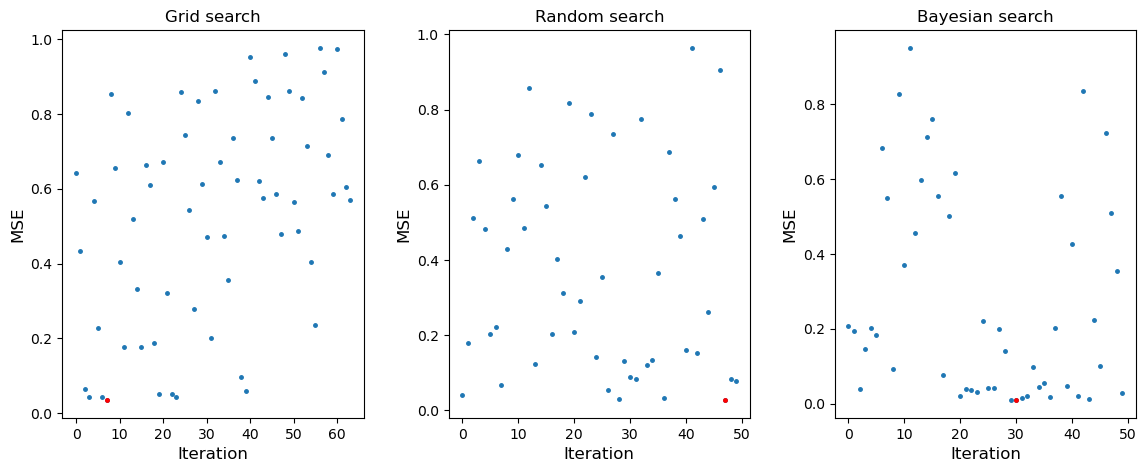

In [25]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.tight_layout(pad = 3)

ax[0].plot(grid_ANN.xs, grid_ANN.ys, 'o', markersize=2.5, color='tab:blue')
ax[0].plot(grid_ANN.opt_xs, grid_ANN.opt_ys, 'o', markersize=2.5, color='red')
ax[0].set_xlabel('Iteration', fontsize=12)
ax[0].set_ylabel('MSE',fontsize=12)
ax[0].set_title('Grid search', fontsize=12)

ax[1].plot(rand_ANN.xs, rand_ANN.ys, 'o', markersize=2.5, color='tab:blue')
ax[1].plot(rand_ANN.opt_xs, rand_ANN.opt_ys, 'o', markersize=2.5, color='red')
ax[1].set_xlabel('Iteration', fontsize=12)
ax[1].set_ylabel('MSE',fontsize=12)
ax[1].set_title('Random search', fontsize=12)


ax[2].plot(bayes_ANN.xs, bayes_ANN.ys, 'o', markersize=2.5, color='tab:blue')
ax[2].plot(bayes_ANN.opt_xs, bayes_ANN.opt_ys, 'o', markersize=2.5, color='red')
ax[2].set_xlabel('Iteration', fontsize=12)
ax[2].set_ylabel('MSE',fontsize=12)
ax[2].set_title('Bayesian search', fontsize=12)

print(f'Grid search: Iteration # for optimized value {grid_ANN.opt_xs}, optimized MSE {grid_ANN.opt_ys}')
print(f'Random search: Iteration # for optimized value {rand_ANN.opt_xs}, optimized MSE {rand_ANN.opt_ys}')
print(f'Bayesian opt: Iteration # for optimized value {bayes_ANN.opt_xs}, optimized MSE {bayes_ANN.opt_ys}')


plt.show()

Each figure represents the iteration-MSE plot for grid search, random search, and bayesian search. The red scatter plot indicates the minimum MSE value during the iteration. Also, the minimum MSE value and iteration number when the minimum MSE was obtained are shown above the figures. The comparison of different methods can be seen in more detail from the next code block

**►** Iteration-MSE plot for each search method in single figure and table summarizing the results:

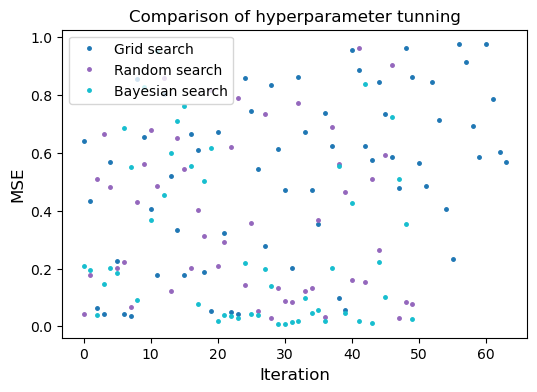

Table 4
╒═══════════════╤═════════════════════╤══════════════════════╤══════════════════════╕
│               │ grid                │ rand                 │ bayes                │
╞═══════════════╪═════════════════════╪══════════════════════╪══════════════════════╡
│ Minimum MSE   │ 0.03442926659811804 │ 0.027389683448483373 │ 0.009146757449713239 │
├───────────────┼─────────────────────┼──────────────────────┼──────────────────────┤
│ learning_rate │ 0.001               │ 0.005                │ 0.01                 │
├───────────────┼─────────────────────┼──────────────────────┼──────────────────────┤
│ activation    │ relu                │ relu                 │ relu                 │
├───────────────┼─────────────────────┼──────────────────────┼──────────────────────┤
│ epochs        │ 100                 │ 50                   │ 100                  │
├───────────────┼─────────────────────┼──────────────────────┼──────────────────────┤
│ nerons        │ 10                  │ 9     

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(grid_ANN.xs, grid_ANN.ys, 'o', markersize=2.5, color='tab:blue', label='Grid search')
ax.plot(rand_ANN.xs, rand_ANN.ys, 'o', markersize=2.5, color='tab:purple', label='Random search')
ax.plot(bayes_ANN.xs, bayes_ANN.ys, 'o', markersize=2.5, color='tab:cyan', label='Bayesian search')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('MSE',fontsize=12)
ax.set_title('Comparison of hyperparameter tunning', fontsize=12)
ax.legend()

plt.show()

# Dictionary for optimized hyperparmeters from different methods
grid_opt_params_ANN = {
    'learning_rate': grid_ANN.best_params_['learning_rate'],
    'activation': grid_ANN.best_params_['activation'],
    'epochs': grid_ANN.best_params_['epochs'],
    'neurons': grid_ANN.best_params_['neurons'],
    'dropout': grid_ANN.best_params_['dropout']
}

rand_opt_params_ANN = {
    'learning_rate': rand_ANN.best_params_['learning_rate'],
    'activation': rand_ANN.best_params_['activation'],
    'epochs': rand_ANN.best_params_['epochs'],
    'neurons': rand_ANN.best_params_['neurons'],
    'dropout': rand_ANN.best_params_['dropout']
}

bayes_opt_params_ANN = {
    'learning_rate': bayes_ANN.best_params_['learning_rate'],
    'activation': bayes_ANN.best_params_['activation'],
    'epochs': bayes_ANN.best_params_['epochs'],
    'neurons': bayes_ANN.best_params_['neurons'],
    'dropout': bayes_ANN.best_params_['dropout']
}

# Build table to summarize the results 
table = [
    ['Minimum MSE', grid_ANN.opt_ys, rand_ANN.opt_ys, bayes_ANN.opt_ys],
    ['learning_rate', grid_opt_params_ANN['learning_rate'], rand_opt_params_ANN['learning_rate'], bayes_opt_params_ANN['learning_rate']],
    ['activation', grid_opt_params_ANN['activation'], rand_opt_params_ANN['activation'], bayes_opt_params_ANN['activation']],
    ['epochs', grid_opt_params_ANN['epochs'], rand_opt_params_ANN['epochs'], bayes_opt_params_ANN['epochs']],
    ['nerons', grid_opt_params_ANN['neurons'], rand_opt_params_ANN['neurons'], bayes_opt_params_ANN['neurons']],
    ['dropout', grid_opt_params_ANN['dropout'], rand_opt_params_ANN['dropout'], bayes_opt_params_ANN['dropout']]
        ]

print('Table 4')
print(tabulate(table, headers=['grid', 'rand', 'bayes'], tablefmt='fancy_grid'))

The restuls are similar to random forest regressor example.
* Grid search requires about 60 iterations to get the optimum hyperparameter while random and bayesian search obtained the minimum MSE from less than 50 iterations. However, 60 iteration of grid search has limited search space compared to random search or bayesian search
* Bayesian search showed minimum MSE. this is because it was able to expand the search space compared to grid search (it will require too much time if we use the same search space for grid search). Also it perforemed better than random search 
* Bayaesian approach shows significant advantages in this model since the model is complicate with large number of hyperparameteres to tune
* The optimized hyperparameters for each method are summarized in table 4 

**►** Refit the model with obtained hyperparameter with entire training data and calculate the MSE for training and testing data:

In [27]:
model_grid_ANN = KerasRegressor(**grid_opt_params_ANN, build_fn = ANN_regressor)     # Train ANN regressor from hyperparameter from grid search
model_grid_ANN.fit(X_train_sc, y_train_sc, verbose=0)
y_pred_train_grid_ANN = model_grid_ANN.predict(X_train_sc)
y_pred_test_grid_ANN = model_grid_ANN.predict(X_test_sc)

model_rand_ANN = KerasRegressor(**rand_opt_params_ANN, build_fn = ANN_regressor)     # Train ANN regressor from hyperparameter from random search
model_rand_ANN.fit(X_train_sc, y_train_sc, verbose=0)
y_pred_train_rand_ANN = model_rand_ANN.predict(X_train_sc)
y_pred_test_rand_ANN = model_rand_ANN.predict(X_test_sc)

model_bayes_ANN = KerasRegressor(**bayes_opt_params_ANN, build_fn = ANN_regressor)   # Train ANN regressor from hyperparameter from bayes search
model_bayes_ANN.fit(X_train_sc, y_train_sc, verbose=0)
y_pred_train_bayes_ANN = model_bayes_ANN.predict(X_train_sc)
y_pred_test_bayes_ANN = model_bayes_ANN.predict(X_test_sc)

mse_train_grid_ANN = mean_squared_error(y_train_sc, y_pred_train_grid_ANN)
mse_train_rand_ANN = mean_squared_error(y_train_sc, y_pred_train_rand_ANN)
mse_train_bayes_ANN = mean_squared_error(y_train_sc, y_pred_train_bayes_ANN)

mse_test_grid_ANN = mean_squared_error(y_test_sc, y_pred_test_grid_ANN)
mse_test_rand_ANN = mean_squared_error(y_test_sc, y_pred_test_rand_ANN)
mse_test_bayes_ANN = mean_squared_error(y_test_sc, y_pred_test_bayes_ANN)

**►** Regression results for training data from optained hyperparameter from each method:

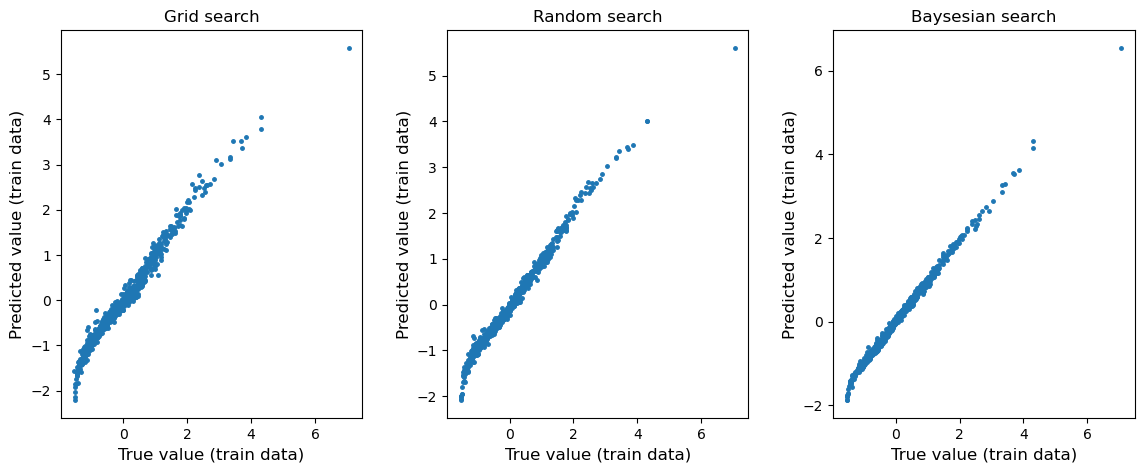

Table 5
╒═════════════════════╤═══════════╤═══════════╤════════════╕
│                     │      grid │      rand │      bayes │
╞═════════════════════╪═══════════╪═══════════╪════════════╡
│ MSE (training data) │ 0.0228405 │ 0.0141569 │ 0.00525091 │
╘═════════════════════╧═══════════╧═══════════╧════════════╛


In [30]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.tight_layout(pad = 3)

ax[0].plot(y_train_sc, y_pred_train_grid_ANN, 'o', markersize=2.5, color='tab:blue')     
ax[0].set_xlabel('True value (train data)', fontsize=12)
ax[0].set_ylabel('Predicted value (train data)',fontsize=12)
ax[0].set_title('Grid search', fontsize=12)

ax[1].plot(y_train_sc, y_pred_train_rand_ANN, 'o', markersize=2.5, color='tab:blue')     
ax[1].set_xlabel('True value (train data)', fontsize=12)
ax[1].set_ylabel('Predicted value (train data)',fontsize=12)
ax[1].set_title('Random search', fontsize=12)

ax[2].plot(y_train_sc, y_pred_train_bayes_ANN, 'o', markersize=2.5, color='tab:blue')    
ax[2].set_xlabel('True value (train data)', fontsize=12)
ax[2].set_ylabel('Predicted value (train data)',fontsize=12)
ax[2].set_title('Baysesian search', fontsize=12)

plt.show()

print('Table 5')
table = [['MSE (training data)', mse_train_grid_ANN, mse_train_rand_ANN, mse_train_bayes_ANN]]
print(tabulate(table, headers=['grid', 'rand', 'bayes'], tablefmt='fancy_grid'))

plt.show()

Table 5 summarizes the MSE from training data. Bayesian optimization showed lowest MSE

**►** Regression results for testing data from optained hyperparameter from each method:

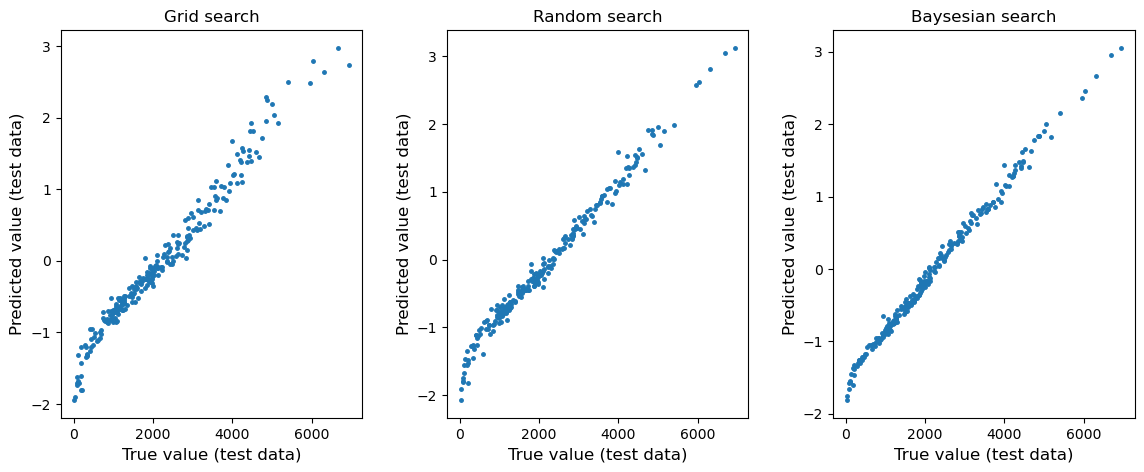

Table 6
╒════════════════════╤═══════════╤═══════════╤═══════════╕
│                    │      grid │      rand │     bayes │
╞════════════════════╪═══════════╪═══════════╪═══════════╡
│ MSE (testing data) │ 0.0259672 │ 0.0135175 │ 0.0058974 │
╘════════════════════╧═══════════╧═══════════╧═══════════╛


In [31]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.tight_layout(pad = 3)

ax[0].plot(y_test, y_pred_test_grid_ANN, 'o', markersize=2.5, color='tab:blue')
ax[0].set_xlabel('True value (test data)', fontsize=12)
ax[0].set_ylabel('Predicted value (test data)',fontsize=12)
ax[0].set_title('Grid search', fontsize=12)

ax[1].plot(y_test, y_pred_test_rand_ANN, 'o', markersize=2.5, color='tab:blue')
ax[1].set_xlabel('True value (test data)', fontsize=12)
ax[1].set_ylabel('Predicted value (test data)',fontsize=12)
ax[1].set_title('Random search', fontsize=12)

ax[2].plot(y_test, y_pred_test_bayes_ANN, 'o', markersize=2.5, color='tab:blue')
ax[2].set_xlabel('True value (test data)', fontsize=12)
ax[2].set_ylabel('Predicted value (test data)',fontsize=12)
ax[2].set_title('Baysesian search', fontsize=12)

plt.show()

print('Table 6')
table = [['MSE (testing data)', mse_test_grid_ANN, mse_test_rand_ANN, mse_test_bayes_ANN]]
print(tabulate(table, headers=['grid', 'rand', 'bayes'], tablefmt='fancy_grid'))

plt.show()

Table 6 summarizes the MSE from testing data. Bayesian optimization showed lowest MSE 

### 8. Summary and Conclusion

Three different hyperparameter tuning methods which are 1) grid search 2) random search 3) bayesian optimization was compared using random forest regressor and ANN regressor with subsurface data. <br/>
Hyperparameters optained from Bayeisian optimization showed best performances (lowest MSE) in two regression models. Especially the the ANN model was significantly improved compared to random forest model.
Therefore, for model with rich hyperparameters and hyperparameter within large search space, bayesian optimization is recommended and this can reduce the time for tuning and improve the model performance.
Below summarizes the pros and cons of each method 

<p align="center">
    <img src="https://github.com/dyyoon91//ML_lecture//blob//main//Summary_table.png?raw=true" width="900" height="900" />
</p>



### 9. Appendix
Bayeisan approaches in contrast to grid search or random search, keep track of past evaluation.
The Bayesian optimization process is:

**for** t= 1, 2,... **do** <br/>
$\;\;\;\;\;$1. Find $X_{t}$ which acquisition function is maximum <br/>
$\;\;\;\;\;\;\;\;$$x_{t}$ = argmax(u(X|$D_{1:t-1}$)) <br/>
$\;\;\;\;\;\;$2.Sample the objective function: <br/>
$\;\;\;\;\;\;\;\;$$y_{t}$ = f($X_{t}$) <br/>
$\;\;\;\;\;\;$3.Augment the data $D_{1:t}$ = {$D_{1:t}$, (**$X_{t}$**,$y_{t}$)} and update the surrogate function <br/>
**end for**
Where **X** is the vector of hyperparameters we are trying to optimize,  <br/>

Bayesian optimization tries to optimize the model by optimizing the objective function, which is usually the score (i.e., MSE) that we want to minimize or maximize. However, since we do not know the true value of objective function bayesian optimization uses surrogate model which approximates the objective function. Surrogate model (posterior) is continuoulsy updated by the new observation (new hyperparameters) which is step 3 in above algorithm which can be also written as P(score|hyperparameter) <br/>

There are several types of surrogate model which includes Gaussian Processes, Random Forest Regression, Tree Parzen Estimator (TPE) <br/>

Below figure shows the example of Bayesian optimization process with gaussian surrogate function. From the current data, the next observation is selected from acquisition function (also shown in algorithm step 1). The acquisition function returns the value based on the trade off of exploitation and exploration. Exploitation means sampling where the surrogate model prdicts a high objective and exploitation means sampling locations where the prediction uncertainty is high. Three widely used acquisition functions are: 1) Upper Confidence Bound, 2)Probability of Improvement (PI), and Expected Improvement (EI). <br/> 
(The example in this work applies TPE as the surrogate model and EI as the acquisition function)

<p align="center">
    <img src="https://github.com/dyyoon91//ML_lecture//blob//main//BayesianOpt_Appendix9_1-min.png?raw=true" width="600" height="600" />
</p>

There is a very nice lecture for bayesian optimization in YouTube which the course is from UBC by Nando de Freitas 
https://www.youtube.com/watch?v=vz3D36VXefI&t=1321s

### References

* https://towardsdatascience.com/shallow-understanding-on-bayesian-optimization-324b6c1f7083

* http://hyperopt.github.io/hyperopt/

* https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Regression.ipynb

* https://github.com/GeostatsGuy/GeoDataSets

* https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Gradient_Boosting.ipynb



**►** __This workflow was prepared during Fall 2022 semester by:__

## Dongyoung Yoon
### PhD Student at the University of Texas at Austin   

##### [Email]: dyyoon@utexas.edu [LinkedIn] www.linkedin.com/in/dongyoung1008